#Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#Carregamento de dados e processamento

In [ ]:
#Importar dados
df = pd.read_pickle("/content/drive/MyDrive/TCC_PUC/Pickle/processed_data.pkl")
#Definir colunas categóricas
category_cols = ['iptuType','rentalAdministrator','condoType','type','availabilityType','ownership']
#One Hot Encoder
enc = OneHotEncoder(dtype=np.int8)
enc_region = OneHotEncoder(dtype=np.int8, handle_unknown='infrequent_if_exist',min_frequency=69)
transformed = enc.fit_transform(df[category_cols])
ohe_df = pd.DataFrame(transformed.todense(),columns=enc.get_feature_names_out(),index=df.index)
df = pd.concat([df, ohe_df], axis=1).drop(category_cols,axis=1)
transformed = enc_region.fit_transform(df[['region_id']])
ohe_df = pd.DataFrame(transformed.todense(),columns=enc_region.get_feature_names_out(),index=df.index)
df = pd.concat([df, ohe_df], axis=1).drop(['region_id'],axis=1)

##Divisão dos dados

In [ ]:
# Definição do X e drop das colunas
X = df.drop(['rentPrice','totalCost','rentalGuarantee_max','rentalGuarantee_min','homeProtection'],axis=1)
# Definição do y
y = df['totalCost']
# Divisão entre treino e teste
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2, random_state=0)

#Dummy - Linha de base

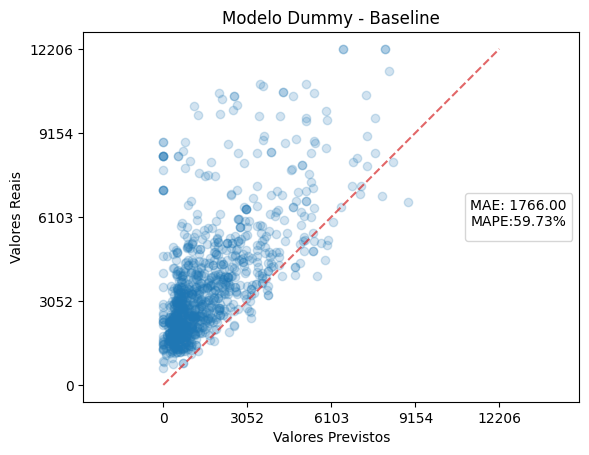

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
dummy = xtrain.apply(lambda r: r['iptu']*10+r['condoPrice'], axis=1)
chart = PredictionErrorDisplay.from_predictions(
        y_true=ytrain,y_pred=dummy,kind="actual_vs_predicted",
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},line_kwargs={"color": "tab:red"})
chart.ax_.set_title('Modelo Dummy - Baseline')
chart.ax_.set_xlabel('Valores Previstos')
chart.ax_.set_ylabel('Valores Reais')
chart.ax_.legend(loc="center right",title=f"MAE: {median_absolute_error(ytrain,dummy ):.2f}\nMAPE:{mean_absolute_percentage_error(ytrain,dummy):.2%}")
plt.show()

#Modelagem

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

estimators = [
    ("KNN", KNeighborsRegressor()),
    ("RandomForest", RandomForestRegressor()),
    ("HistGradientBoosting", HistGradientBoostingRegressor())
]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())


##Treino e Cross-validation

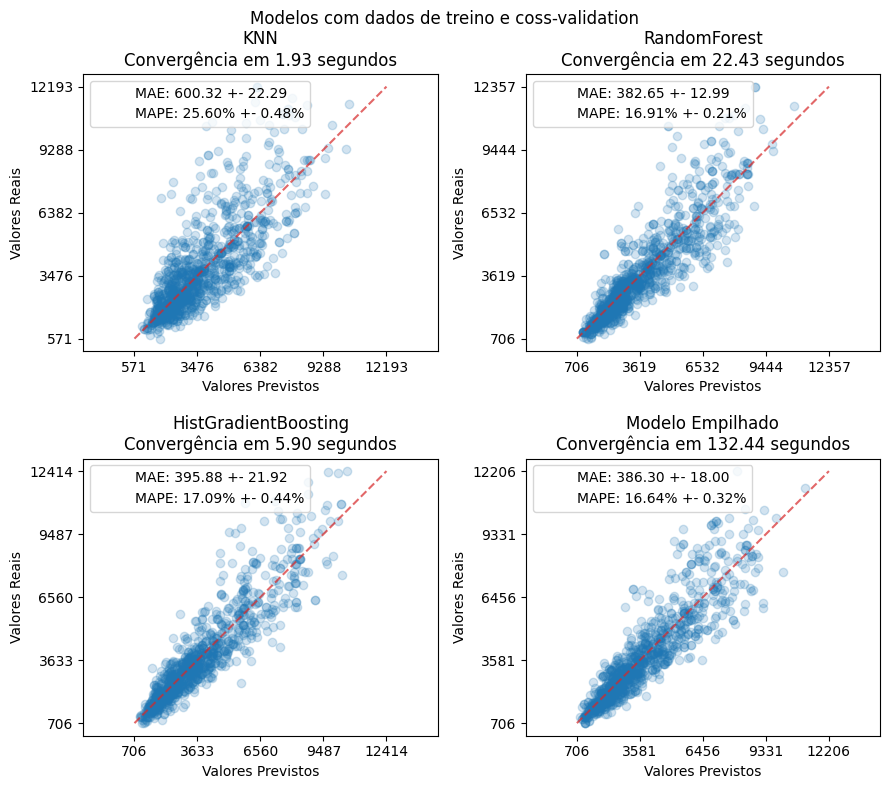

In [ ]:
#Adaptado do código da documentação disponível em:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html

import time
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate
best_model = []
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = np.ravel(axs)
for ax, (name, est) in zip(axs, estimators
                           + [("Modelo Empilhado", stacking_regressor)]
                           ):
    # definição dos scores
    scorers = { 'MAE':'neg_median_absolute_error','MAPE':'neg_mean_absolute_percentage_error'}
    start_time = time.time()
    # cross-validation
    scores = cross_validate(est, xtrain, ytrain, scoring=list(scorers.values()), n_jobs=-1, verbose=0,return_estimator=True)
    elapsed_time = time.time() - start_time
    # seleção do melhor modelo
    i = scores['test_neg_median_absolute_error']
    i = np.where(i == i.max())[0][0]
    best_model.append((name,scores['estimator'][i]))
    # predição dos valores
    y_pred = cross_val_predict(est, xtrain, ytrain, n_jobs=-1, verbose=0)
    # configuração do gráfico
    legenda = {}
    for key, value in scorers.items():
      if key == 'MAPE':
        legenda[key] = f"{np.abs(np.mean(scores[f'test_{value}'])):.2%} +- {np.std(scores[f'test_{value}']):.2%}"
      elif key == 'MAE':
        legenda[key] = f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- {np.std(scores[f'test_{value}']):.2f}"
    display = PredictionErrorDisplay.from_predictions(
        y_true=ytrain,y_pred=y_pred,kind="actual_vs_predicted",ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nConvergência em {elapsed_time:.2f} segundos")
    ax.set_xlabel('Valores Previstos')
    ax.set_ylabel('Valores Reais')
    for name, score in legenda.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
plt.suptitle("Modelos com dados de treino e coss-validation\n")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Teste

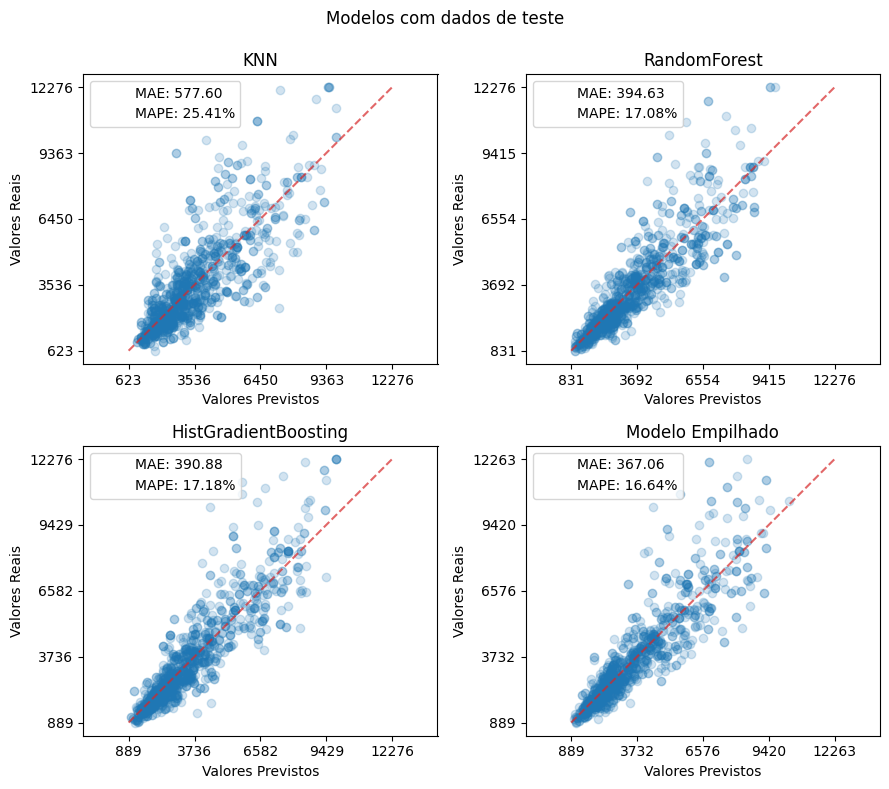

In [ ]:
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = np.ravel(axs)
for ax, (name, est) in zip(axs, best_model
                           + [("Modelo Empilhado", stacking_regressor)]
                           ):
    start_time = time.time()
    elapsed_time = time.time() - start_time
    legenda = {}
    y_pred = est.predict(xtest)
    legenda['MAE'] = f"{median_absolute_error(ytest,y_pred ):.2f}"
    legenda['MAPE'] = f"{mean_absolute_percentage_error(ytest,y_pred):.2%}"
    display = PredictionErrorDisplay.from_predictions(
        y_true=ytest,y_pred=y_pred,kind="actual_vs_predicted",ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}")#\nConvergência em {elapsed_time:.2f} segundos")
    ax.set_xlabel('Valores Previstos')
    ax.set_ylabel('Valores Reais')
    for name, score in legenda.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")
plt.suptitle("Modelos com dados de teste\n")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Permutation Importance

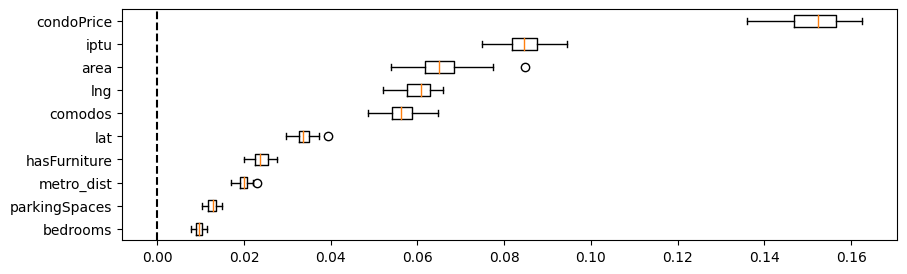

In [ ]:
from sklearn.inspection import permutation_importance
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
result = permutation_importance(best_model[1][1], xtest, ytest,
      n_repeats=30,random_state=0, scoring='neg_mean_absolute_percentage_error')
perm_sorted_idx = result.importances_mean.argsort()
ax.boxplot(
    result.importances[perm_sorted_idx[-10:]].T,
    vert=False,
    labels=X.columns[perm_sorted_idx[-10:]],
)
ax.axvline(x=0, color="k", linestyle="--")